In [1]:
%matplotlib inline

In [2]:
import Signal
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.signal as sig
import sys
from scipy.signal import freqz
from scipy.signal import butter, lfilter
import scipy.signal as signal
from scipy import fftpack
from numpy import linalg as LA
import time

## Generate Signal

In [3]:
def graph_signals(time_axis, array, signalNum=0, timestart = 0.06, dur=0.0001, sr=1000000):
    time_axis = np.array(time_axis)*1000
    timeIdx = int(timestart*sr)
    print(timeIdx)
    durIdx = int(dur*sr)
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[0][timeIdx:timeIdx+durIdx],'b-',color="green")
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[1][timeIdx:timeIdx+durIdx],'b-',color="red")
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[2][timeIdx:timeIdx+durIdx],'b-',color="blue")
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[3][timeIdx:timeIdx+durIdx],'b-',color="purple")
    plt.xlabel('Time (ms)')
    plt.ylabel('Charge (arbitrary)')
    plt.show()
    signals = []
    for signal in array:
        signals.append((time_axis[timeIdx:timeIdx + durIdx], signal[timeIdx:timeIdx+durIdx]))
    return signals

In [4]:
random.seed(1)
source = [0,0.01] #m
coords = [[-0.01, 0], [0, 0], [.01, 0], [.02, 0]]
freq = 20000 #Hz
sos = 1531 #m/s (MAY NEED TO BE CALIBRATED)
sr = 300000 #Hz
read = 1.8 #s
noise = 0.5 #standard deviation
time_on = .01 #s --ping duration
ping_period = 2 #s
ping_start = 1
#create an array containing the simulated readings arrays of each sensor
signals = []
for i in range(len(coords)):
    signals.append(Signal.Signal(source, coords[i], freq, sos, sr, read, noise, time_on, ping_period, ping_start).signals)
times = np.arange(0, read, 1/sr)

1.0000092371885196
1.0000065316786415
1.0000092371885196
1.0000146052774495


300000


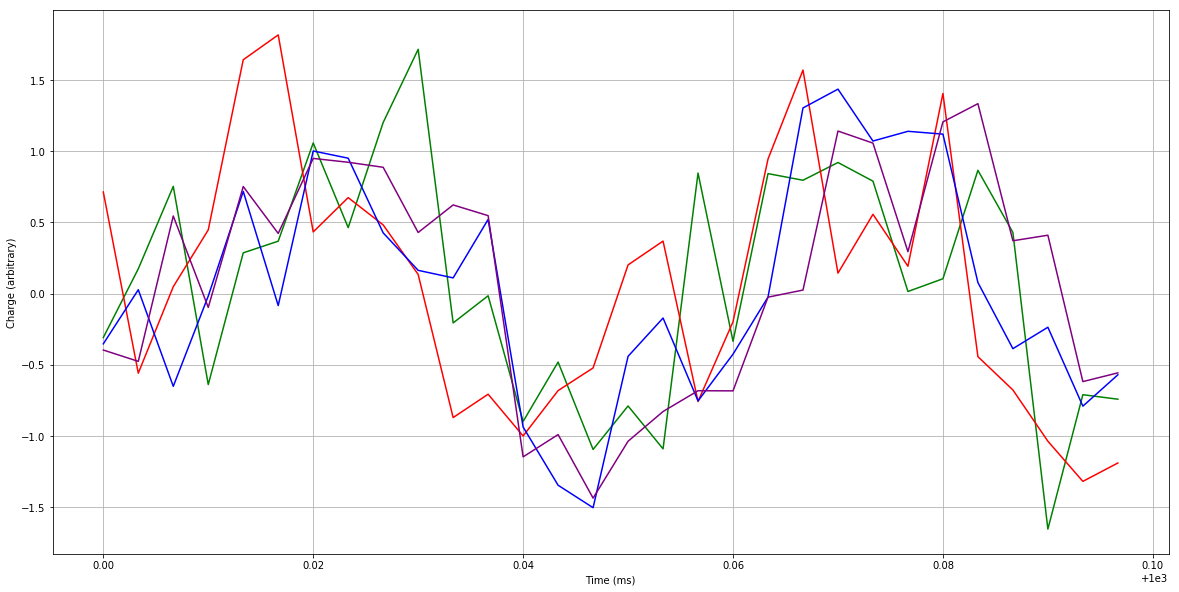

In [5]:
short_signals = graph_signals(times, signals, timestart=1.00,sr=sr)

# STFT-Based Localization

In [52]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [53]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [302]:
def bandpassFilter1(signal):
    diff = freq*.1
    lowcut = (freq-diff)*1000
    highcut = (freq+diff)*1000
    t = signal[0]
    y = butter_bandpass_filter(signal, lowcut, highcut, sr*1000, order=2)
    return y

In [309]:
random.seed(1)
#source = [0,1]
#source = [-math.sqrt(2),math.sqrt(2)] #m
#source = [-math.sqrt(2),math.sqrt(2)] #m
source = [1/2,1/2*math.sqrt(3)] #m
coords = [[-.01/math.sqrt(2), -.01/math.sqrt(2)], [0, 0], [.01/math.sqrt(2), -.01/math.sqrt(2)], [0, -.01]]
freq = 40000 #Hz
sos = 1531 #m/s (MAY NEED TO BE CALIBRATED)
sr = 300000 #Hz
read = 1.8 #s
noise = 0.4 #standard deviation
time_on = .01 #s --ping duration
ping_period = 2 #s
ping_start = 1
#create an array containing the simulated readings arrays of each sensor
signals = []
for i in range(len(coords)):
    signals.append(Signal.Signal(source, coords[i], freq, sos, sr, read, noise, time_on, ping_period, ping_start).signals)
times = np.arange(0, read, 1/sr)

1.0006594791479944
1.000653167864141
1.0006548887783
1.000658832558222


In [310]:
#TODO: Create better wave-front estimation
#(Power of signals?)
#(Envelopes?)
#Create faster flitering algo 
#Currently, more noise = wayy more time

total_start = time.time()
times = []
filtered_signals = []
plot=False
for arrNum in range(4):
    start = time.time()
    time_threshold = .08
    freq_threshold = 10
    num_threshold = 0
    window = 30
    offset = 0
    if True:
        filtered_signal = bandpassFilter1(signals[arrNum])
    else: #OFFSET NOT WORKING CORRECTLY
        window = 4000 #Change this to speed up/slow down code
        est = times[0]
        lbound = int(est-window/2)
        ubound = int(est+2*window)
        if lbound < 0:
            lbound = 0
        elif ubound > len(signals[arrNum])-1:
            ubound = -1
        short_signal = signals[arrNum][lbound:ubound]
        filtered_signal = bandpassFilter1(short_signal)
        offset = lbound
    idx = []
    #This can change number of times you are iterating, and massively speed up code in exchange for accuracy.
    #Adjust so code takes about 2 sec to run.
    ignore = 10 
    
    filtered_signal1 = filtered_signal[::ignore]
    idx = ignore*np.where(np.array(filtered_signal1)>time_threshold)[0]
    count = 0
    for i in idx:
        count=count+1
        lbound = i-window
        ubound = i+window
        if lbound < 0:
            lbound = 0
        if ubound >= len(filtered_signal):
            ubound = len(filtered_signal)-1
        X = fftpack.fft(filtered_signal[lbound:ubound])
        freqs = fftpack.fftfreq(len(filtered_signal[lbound:ubound])) * sr
        freqIdx = np.where(freqs == freq)
        threshold = np.abs(X[freqIdx[0]])
        if threshold > freq_threshold:
            times.append(i+offset)
            break
    print(times[arrNum]/sr)
print("Time Ran: "+str(time.time()-total_start))

1.0007666666666666
1.0007333333333333
1.0007333333333333
1.0007666666666666
Time Ran: 1.6396453380584717


In [311]:
#FILTERED_SIGNALS OR SIGNALS????
phases = []
phase_data = []
maxTime = max(times)
print("TIME: " +str(maxTime/sr))
#maxTime = int(1.00139*sr)
f_window=15
lbound = maxTime
ubound = maxTime+f_window*2

for arrNum in range(4):
    if lbound < 0:
        lbound = 0
    if ubound >= len(signals[arrNum]):
        ubound = len(signals[arrNum])-1
    phase_info = signals[arrNum][lbound:ubound]
    phase_data.append(phase_info)
    X = fftpack.fft(signals[arrNum][lbound:ubound])
    freqs = fftpack.fftfreq(len(signals[arrNum][lbound:ubound])) * sr
    freqIdx = np.where(freqs == freq)
    complexMag = X[freqIdx[0][0]]
    print(complexMag)
    phase = np.angle(complexMag,deg=False)
    phases.append(phase)
    print(phase)
print("------------------------------------------")
print(phases)


TIME: 1.0007666666666666
(13.104951634584276+6.35451822584943j)
0.451490301759322
(-2.678374663857257+13.301393788603136j)
1.7694996705536776
(2.974390076448422+15.048476631994932j)
1.3756576479532145
(16.77109052872007+6.770935471538688j)
0.3837148351730664
------------------------------------------
[0.451490301759322, 1.7694996705536776, 1.3756576479532145, 0.3837148351730664]


In [312]:
bearing = -math.atan((phases[2]-phases[0])/(2*(phases[2]-phases[1])-(phases[2]-phases[0])))
print(np.degrees(bearing))

28.363023486219774


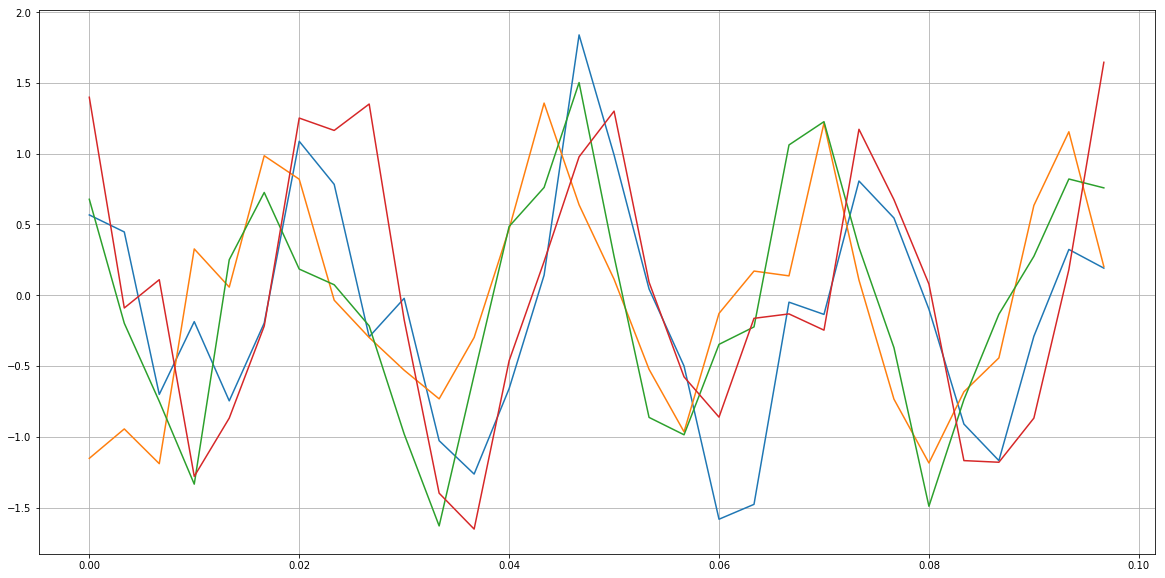

In [313]:
plt.figure(figsize=(20,10))
plt.grid(True)
t = np.arange(0, len(phase_data[0]))/sr*1000
for phase_info in phase_data:
    plt.plot(t,phase_info)
plt.show()

# MUSIC ALGORITHM

## Generate Signals

In [123]:
#TODO:Debug Code, add filtered signals in, remove x-axis dependency
random.seed(1)
source = [0,0.01] #m
coords = [[0, 0], [0.01, 0], [.02, 0], [.03, 0]]
freq = 40000 #Hz
sos = 1531 #m/s (MAY NEED TO BE CALIBRATED)
sr = 300000 #Hz
read = 1.8 #s
noise = 0.1 #standard deviation
time_on = .01 #s --ping duration
ping_period = 2 #s
ping_start = 1
#create an array containing the simulated readings arrays of each sensor
signals = []
for i in range(len(coords)):
    signals.append(Signal.Signal(source, coords[i], freq, sos, sr, read, noise, time_on, ping_period, ping_start).signals)
times = np.arange(0, read, 1/sr)

1.0000065316786415
1.0000092371885196
1.0000146052774495
1.0000206549814512


## Compute Autocorrelation Matrix

In [124]:
signals = np.array(signals)
Rx = 1/4*np.matmul(signals,signals.conj().T)
print(Rx)

[[1726.63131347  295.91692896 -168.00629999 -346.24681653]
 [ 295.91692896 1726.77108342   81.69018824 -362.62509737]
 [-168.00629999   81.69018824 1727.40592807   23.23233003]
 [-346.24681653 -362.62509737   23.23233003 1725.49731506]]


In [125]:
w, v = LA.eig(Rx)
desired = v[1]
noise = []
for i in range(1,4):
    noise.append(v[i].T)
noise=np.array(noise)
print(noise)

[[ 0.55753068 -0.33398046  0.2799408   0.70657608]
 [-0.09526792 -0.89901703  0.13812176 -0.40449324]
 [-0.5941389   0.08944488  0.77264831  0.20497117]]


In [126]:
P_inv = np.matMul(noise,noise.conj().T)

AttributeError: module 'numpy' has no attribute 'matMul'